Lien vers Veille Tech :
https://docs.google.com/document/d/1q6n9m-iSqd-StsmEKDcuAbyZLf_SIY0RGdv-Ledsvxk/edit?usp=sharing

https://www.kaggle.com/datasets/feyzazkefe/trashnet

In [68]:
import os
import numpy as np
import splitfolders
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications import ResNet50, ResNet50V2, VGG16

In [3]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

100%|██████████| 40.8M/40.8M [00:45<00:00, 943kB/s] 

Extracting files...


Path to dataset files: /Users/nana/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


In [69]:
path = "/Users/nana/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1"

In [70]:
folders = os.listdir(path)
print(folders)
# path only goes to one big folder "dataset-resized" / must adjust path
trash_classes_path = os.path.join(path, "dataset-resized")
trash_classes = os.listdir(trash_classes_path)
print(trash_classes)

['dataset-resized']
['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


## Option 1 : keep images in folders

In [7]:
# split data into train, validation and test folders
splitfolders.ratio(trash_classes_path,seed=1337, output="trash-Splitted", ratio=(0.7, 0.15, 0.15))

Copying files: 2527 files [00:00, 4690.25 files/s]


In [8]:
# define paths to train, validation and test folders
train_path = 'trash-Splitted/train/'
val_path = 'trash-Splitted/val/'
test_path = 'trash-Splitted/test/'

In [9]:
# Select a few random images to be displayed
random_images = []
for trash_class in os.listdir(train_path):
  class_path = os.path.join(train_path, trash_class) #define path to each trash_folder
  image_files = os.listdir(class_path) # get all files from trash_folder
  for f in random.sample(image_files,2): #randomly select 2 files in folder
    random_images.append(os.path.join(class_path, f)) # append file path to list "images"

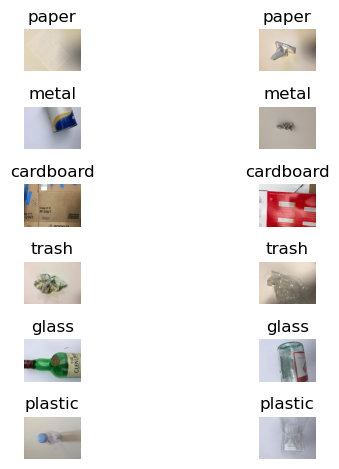

In [ ]:
# Display them
fig, axes = plt.subplots(len(trash_classes), 2)
for index, image_path in enumerate(random_images):
  image = Image.open(image_path)
  ax = axes[index//2, index%2] #positionning images along the axis to not overlap
  ax.imshow(image) #show data as image
  ax.axis('off')  #don't show axis lines
  ax.set_title(os.path.basename(os.path.dirname(image_path))) #get trash type from folder's names

plt.tight_layout()
plt.show()

## Option 2 : regroup files in df

In [71]:
# test on 1 image from metal folder
folder_path = os.path.join(trash_classes_path,"metal")
img_size = (128,128)
img = Image.open(os.path.join(folder_path,"metal1.jpg")).convert('RGB')
img = img.resize(img_size)
photo = np.array(img)
len(photo)

128

In [72]:
categories = {category: index for index, category in enumerate(sorted(trash_classes))}
categories

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [73]:
images = []
labels = []

for folder in sorted(trash_classes):
    class_path = os.path.join(trash_classes_path,folder)
    for files in os.listdir(class_path):
        folder_path = os.path.join(trash_classes_path,folder)
        try:
            img = Image.open(os.path.join(folder_path,files)).convert('RGB')
            img = img.resize(img_size)
            images.append(np.array(img))
            labels.append(categories[folder])
        except Exception as e:
                    print(f"Error loading image {files}: {e}")


In [74]:
len(images)

2527

In [75]:
labels = np.array(labels)
images = np.array(images)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
y_train = to_categorical(y_train, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [77]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [78]:
X_train.shape

(1515, 128, 128, 3)

In [83]:
model = Sequential([
    Flatten(input_shape=(128,128,3)),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model = model.fit(
    X_train,y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1897 - loss: 20.2344 - val_accuracy: 0.3775 - val_loss: 4.3175
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3139 - loss: 3.4014 - val_accuracy: 0.3874 - val_loss: 1.7354
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3818 - loss: 2.0504 - val_accuracy: 0.3972 - val_loss: 2.2988
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3305 - loss: 2.9505 - val_accuracy: 0.2273 - val_loss: 3.3138
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3091 - loss: 3.4749 - val_accuracy: 0.2609 - val_loss: 4.4027
